In [410]:
%matplotlib inline
import os
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import re

In [411]:
os.system('rm *.h5 *.xml')

0

Let's use the same material definition as the existing pincell depletion example 

In [412]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

ofc_uo2 = uo2.clone()
ofc_uo2.name = 'UO2_ofc'
# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water, ofc_uo2])

In [413]:
# Define surfaces
width = 1.25984
height = 200
ofc_r = 2
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')
ofc_surf = openmc.Sphere(x0 = 15, r = ofc_r, boundary_type = 'vacuum') 

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
ofc_fuel = openmc.Cell(fill=ofc_uo2, region=-ofc_surf)
# Define overall geometry
geometry = openmc.Geometry([fuel, gap, clad, msr, ofc_fuel])

In [414]:
# Set material volume for depletion.
uo2.volume = pi * fuel_or.r**2 * height
#ofc_uo2.volume = 4/3 * pi * ofc_r**3
ofc_uo2.volume  = uo2.volume 

In [415]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

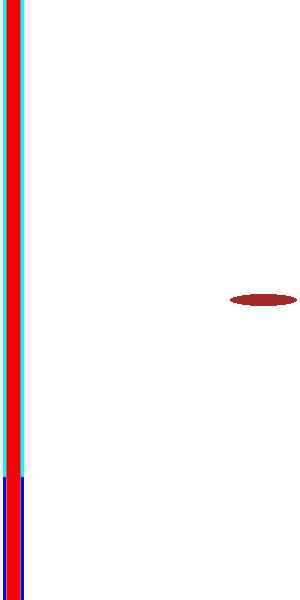

In [416]:
# Create plot
geometry.export_to_xml()
material.export_to_xml()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (18,200)
plot.pixels = (300,600)
plot.color_by = 'material'
plot.colors = {uo2:'red', helium:'cyan', borated_water: 'blue', 
               zircaloy: 'gray', ofc_uo2:'brown'}
openmc.plot_inline(plot)

In [417]:
#Create depletion "operator"
#chain_file = '/home/lorenzo/ca_depletion_chains/chain_simple.xml'
op = openmc.deplete.CoupledOperator(model)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 100000  # W
# Transfer all elements from in-core to out-of-core and vice-versa
all_elements = list(openmc.data.ELEMENT_SYMBOL.values())
all_elements.remove('He')
flow_rate = 1 #litres/sec
lambda_in = 1 / (uo2.volume / 1000 / flow_rate)
lambda_out = 1 / (ofc_uo2.volume / 1000 / flow_rate)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_transfer_rate('UO2', all_elements, lambda_in, destination_material='UO2_ofc')
integrator.add_transfer_rate('UO2_ofc', all_elements, lambda_out, destination_material='UO2')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Sn115 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn115.h5
 Reading Sn116 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn116.h5
 Reading Sn117 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn117.h5
 Reading Sn118 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn118.h5
 Reading Sn119 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn119.h5
 Reading Sn120 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn120.h5
 Reading Sn122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn122.h5
 Reading Sn124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn124.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading B10 from /home/lorenzo/nuclear_data/endfb80_hdf5/B10.h5
 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing di

 Reading Mg24 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Al26_m1.h5
 Reading Al27 from /home/lorenzo/nuclear_data/endfb80_hdf5/Al27.h5
 Reading Si28 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si28.h5
 Reading Si29 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si29.h5
 Reading Si30 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si30.h5
 Reading Si31 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si32.h5
 Reading P31 from /home/lorenzo/nuclear_data/endfb80_hdf5/P31.h5
 Reading S32 from /home/lorenzo/nuclear_data/endfb80_hdf5/S32.h5
 Reading S33 from /home/lorenzo/nuclear_data/endfb80_hdf5/S33.h5
 Reading S34 from /home/lorenzo/nuclear_data/endfb80_hdf5/S34.h5
 Reading S35 from /home/lorenzo/nuclear_data/endfb80_hdf5/S35.h5

 Reading Ar37 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar37.h5
 Reading Ar38 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar38.h5
 Reading Ar39 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/lorenzo/nuclear_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/lorenzo/nuclear_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/lorenzo/nuclear_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca46.h5
 

 Reading Se81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Se81.h5
 Reading Se82 from /home/lorenzo/nuclear_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/lorenzo/nuclear_data/endfb80_hdf5/Rb8

 Reading Nb95 from /home/lorenzo/nuclear_data/endfb80_hdf5/Nb95.h5
 Reading Mo92 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo92.h5
 Reading Mo93 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo93.h5
 Reading Mo94 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo94.h5
 Reading Mo95 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo95.h5
 Reading Mo96 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo96.h5
 Reading Mo97 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo97.h5
 Reading Mo98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo98.h5
 Reading Mo99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo99.h5
 Reading Mo100 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo100.h5
 Reading Tc98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tc98.h5


 Reading Tc99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/lorenzo/nuclear_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/lorenzo/nuclear_data/endfb80_hdf5/Rh104.h5
 Reading Rh105 from /home/lorenzo/nuclear_da

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd108 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/lorenzo/nuclear_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/lorenzo/nuclear_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/lorenzo/nuclear_data/endfb80_hdf5/In115.h5
 Reading Sn113 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn113.h5
 Reading Sn121_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn121_m1.h5
 Reading Sn123 from /h

          1200K
          2500K


 Reading Sb122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/lorenzo/nuclear_data/endfb80_hdf5/I127.h5
 Reading I12

 Reading I132_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/I132_m1.h5
 Reading I133 from /home/lorenzo/nuclear_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/lorenzo/nuclear_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/lorenzo/nu

          2500K


 Reading Cs134 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba131.h5


          1200K
          2500K


 Reading Ba132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba137.h5
 Reading Ba138 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba138.h5
 Reading Ba139 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba139.h5
 Reading Ba140 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba140.h5
 Reading La138 from /home/lorenzo/nuclear_data/endfb80_hdf5/La138.h5
 Reading La139 from /home/lorenzo/nuclear_data/endfb80_hdf5/La139.h5
 Reading La140 from /home/lorenzo/nuclear_data/endfb80_hdf5/La140.h5
 Reading Ce136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce136.h5
 Reading Ce137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce137.h5
 Reading Ce137_m1 from /home/loren

          1200K
          2500K


 Reading Gd153 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/lorenzo/

          1200K
          2500K


 Reading Yb169 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb169.h5
 Reading Yb170 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb174.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb175.h5
 Reading Yb176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf174.h5


          1200K
          2500K


 Reading Hf175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf175.h5
 Reading Hf176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf181.h5
 Reading Hf182 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ta180.h5
 Reading Ta181 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ta181.h5


          1200K
          2500K
          1200K
          2500K


 Reading Ta182 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ta182.h5
 Reading W180 from /home/lorenzo/nuclear_data/endfb80_hdf5/W180.h5
 Reading W181 from /home/lorenzo/nuclear_data/endfb80_hdf5/W181.h5
 Reading W182 from /home/lorenzo/nuclear_data/endfb80_hdf5/W182.h5
 Reading W183 from /home/lorenzo/nuclear_data/endfb80_hdf5/W183.h5
 Reading W184 from /home/lorenzo/nuclear_data/endfb80_hdf5/W184.h5
 Reading W185 from /home/lorenzo/nuclear_data/endfb80_hdf5/W185.h5
 Reading W186 from /home/lorenzo/nuclear_data/endfb80_hdf5/W186.h5
 Reading Re185 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os184.h5
 Reading Os185 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os185.h5
 Reading Os186 from /home/lorenzo/nuclear_data/endfb80_hdf5/Os186.h5
 Reading Os187 from /home/lorenzo/nuclear_

 Reading Bk248 from /home/lorenzo/nuclear_data/endfb80_hdf5/Bk248.h5
 Reading Bk249 from /home/lorenzo/nuclear_data/endfb80_hdf5/Bk249.h5
 Reading Bk250 from /home/lorenzo/nuclear_data/endfb80_hdf5/Bk250.h5
 Reading Cf246 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf246.h5
 Reading Cf247 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf247.h5
 Reading Cf248 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf248.h5
 Reading Cf249 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf249.h5
 Reading Cf250 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf250.h5
 Reading Cf251 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf251.h5
 Reading Cf252 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf252.h5
 Reading Cf253 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf253.h5
 Reading Cf254 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cf254.h5
 Reading Es251 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es251.h5
 Reading Es252 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es252.h5


          1200K


 Reading Es253 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es253.h5
 Reading Es254 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/lorenzo/nuclear_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.62343
        2/1    0.74096
        3/1    0.79541
        4/1    0.83038
        5/1    0.92843
        6/1    0.94411
        7/1    0.95005
        8/1    1.00325
        9/1    1.01972
       10/1    0.94034
       11/1    0.96245
       12/1    0.97955    0.97100 +/- 0.00855
       13/1    1.04670    0.99623 +/- 0.02571
       14/1    0.98346    0.99304 +/- 0.01846
    

       40/1    0.98358    0.96502 +/- 0.00894
       41/1    1.02072    0.96682 +/- 0.00883
       42/1    0.94089    0.96601 +/- 0.00859
       43/1    0.95769    0.96576 +/- 0.00833
       44/1    0.97625    0.96607 +/- 0.00808
       45/1    1.01763    0.96754 +/- 0.00799
       46/1    1.07282    0.97046 +/- 0.00829
       47/1    0.98370    0.97082 +/- 0.00808
       48/1    0.93079    0.96977 +/- 0.00793
       49/1    0.94515    0.96914 +/- 0.00775
       50/1    1.00440    0.97002 +/- 0.00761
       51/1    0.93268    0.96911 +/- 0.00747
       52/1    0.96894    0.96910 +/- 0.00729
       53/1    0.97917    0.96934 +/- 0.00713
       54/1    0.96000    0.96912 +/- 0.00696
       55/1    0.94037    0.96849 +/- 0.00684
       56/1    0.90206    0.96704 +/- 0.00684
       57/1    0.92280    0.96610 +/- 0.00676
       58/1    0.97378    0.96626 +/- 0.00662
       59/1    0.97173    0.96637 +/- 0.00648
       60/1    0.92599    0.96556 +/- 0.00640
       61/1    0.94261    0.96511 

       87/1    0.97034    0.96093 +/- 0.00447
       88/1    0.95139    0.96081 +/- 0.00441
       89/1    0.98939    0.96117 +/- 0.00437
       90/1    0.94017    0.96091 +/- 0.00432
       91/1    1.03561    0.96183 +/- 0.00437
       92/1    0.93120    0.96146 +/- 0.00433
       93/1    1.01629    0.96212 +/- 0.00433
       94/1    1.02497    0.96287 +/- 0.00434
       95/1    0.96586    0.96290 +/- 0.00429
       96/1    0.95356    0.96279 +/- 0.00424
       97/1    0.96942    0.96287 +/- 0.00419
       98/1    1.01871    0.96350 +/- 0.00419
       99/1    1.02636    0.96421 +/- 0.00420
      100/1    1.02104    0.96484 +/- 0.00421
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 5.8074e+01 seconds
   Time in transport only          = 5.7778e+01 seconds
   Time in

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.58262
        2/1    0.66922
        3/1    0.74886
        4/1    0.83138
        5/1    0.90415
        6/1    0.90561
        7/1    1.00916
        8/1    0.92478
        9/1    0.95585
       10/1    0.97643
       11/1    0.89973
       12/1    0.95017    0.92495 +/- 0.02522
       13/1    0.95314    0.93435 +/- 0.01733
       14/1    1.03814    0.96030 +/- 0.02870
       15/1    0.92145    0.95253 +/- 0.02355
       16/1    0.96592    0.95476 +/- 0.01935
       17/1    0.99535    0.96056 +/- 0.01736
       18/1    0.94112    0.95813 +/- 0.01523
       19/1    0.97074    0.95953 +/- 0.01350
       20/1    0.90789    0.95437 +/- 0.01313
       21/1    1.03590    0.96178 +/- 0.01400
       22/1    0.99223    0.96431 +/- 0.01303
       23/1    1.02811    0.96922 +/- 0.01

       49/1    0.91117    0.95033 +/- 0.00658
       50/1    0.96153    0.95061 +/- 0.00642
       51/1    0.96842    0.95105 +/- 0.00627
       52/1    0.89899    0.94981 +/- 0.00625
       53/1    0.94367    0.94966 +/- 0.00610
       54/1    0.96856    0.95009 +/- 0.00598
       55/1    0.94864    0.95006 +/- 0.00584
       56/1    0.99605    0.95106 +/- 0.00580
       57/1    0.94906    0.95102 +/- 0.00568
       58/1    0.98300    0.95169 +/- 0.00560
       59/1    0.92454    0.95113 +/- 0.00551
       60/1    1.04666    0.95304 +/- 0.00573
       61/1    1.04083    0.95476 +/- 0.00587
       62/1    0.98878    0.95542 +/- 0.00579
       63/1    0.90263    0.95442 +/- 0.00577
       64/1    0.90845    0.95357 +/- 0.00573
       65/1    0.94501    0.95341 +/- 0.00562
       66/1    0.92001    0.95282 +/- 0.00555
       67/1    0.93747    0.95255 +/- 0.00546
       68/1    0.91308    0.95187 +/- 0.00541
       69/1    0.88529    0.95074 +/- 0.00544
       70/1    0.92059    0.95024 

In [418]:
from matplotlib.pyplot import Line2D
res = openmc.deplete.Results('depletion_results.h5')

atoms_core = dict()
atoms_ofc = dict()

for nuc in res[0].index_nuc.keys():
    atoms_core[nuc] = res.get_atoms(uo2, nuc)[1]
    atoms_ofc[nuc] = res.get_atoms(ofc_uo2, nuc)[1]

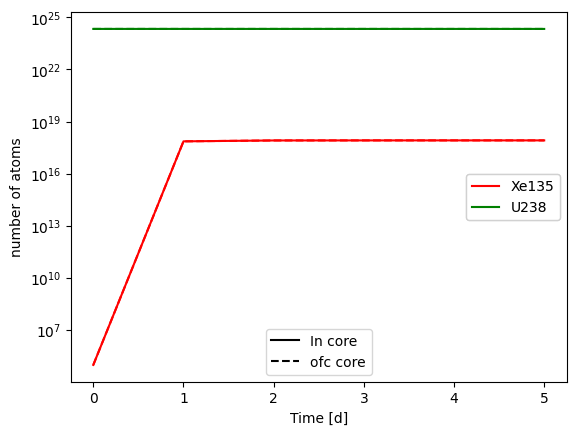

In [419]:
from matplotlib.pyplot import Line2D
line1 = Line2D([0], [0], color='black')
line2 = Line2D([0], [0], linestyle='--', color='black')
line3 = Line2D([0], [0], color='r')
line4 = Line2D([0], [0], color='g')
labels1 = ['In core', 'ofc core']
labels2 = ['Xe135', 'U238']
fig, ax = plt.subplots()
ax.plot(atoms_core['Xe135'], color='r')
ax.plot(atoms_ofc['Xe135'], '--', color='r')
ax.plot(atoms_core['U238'], color='g')
ax.plot(atoms_ofc['U238'], '--', color='g')
leg1=plt.legend([line1, line2],labels1,loc='lower center')
leg2=plt.legend([line3, line4],labels2,loc='center right')
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_xlabel('Time [d]')
ax.set_ylabel('number of atoms')
ax.set_yscale('log')
plt.show()

In [420]:
def add_zero(elm):
    if len(elm) == 1:
        elm = '00'+elm
    elif len(elm) == 2:
        elm = '0'+elm
    return elm

In [421]:
def make_file_string(nuc):
    elm=re.split(r'(\d+|\s+)', nuc)[0]
    A=re.split(r'(\d+|\s+)', nuc)[1]
    Z=openmc.data.ATOMIC_NUMBER[elm]
    A=add_zero(A)
    Z=add_zero(str(Z))
    return f'dec-{Z}_{elm}_{A}.endf'

In [422]:
# if beta-,n decay mode is present, the nuclide is a delayed neutron precurso
def get_dnp(nuc):    
    file = make_file_string(nuc)
    path = '/home/lorenzo/ca_depletion_chains/ENDF-B-VIII.0/ENDF-B-VIII.0_decay'
    if file in os.listdir(path):
        decay_data=openmc.data.Decay.from_endf(f'{path}/{file}')  
        for mode in decay_data.modes:
            if all(decay in mode.modes for decay in ['beta-', 'n']):
                return nuc
        

In [423]:
dnp=[]
for nuc in res[0].index_nuc.keys():
    if get_dnp(nuc):
        dnp.append(nuc)

In [424]:
#DNP Atoms Dictionaries 
atoms_core_dnp = {nuc: atoms_core[nuc] for nuc in dnp}
atoms_ofc_dnp = {nuc: atoms_ofc[nuc] for nuc in dnp}

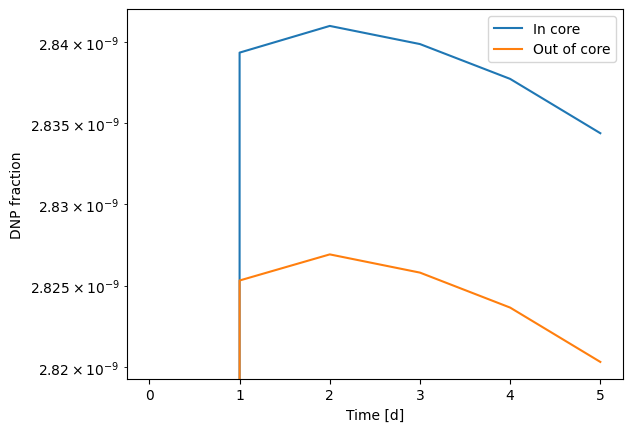

In [429]:
# Calculate DNP fractions
beta_core = sum(atoms_core_dnp.values())/sum(atoms_core.values())
beta_ofc = sum(atoms_ofc_dnp.values())/sum(atoms_ofc.values())
fig, ax = plt.subplots()
ax.plot(beta_core, label='In core')
ax.plot(beta_ofc, label='Out of core')
plt.legend()
ax.set_xlabel('Time [d]')
ax.set_ylabel('DNP fraction')
ax.set_yscale('log')
plt.show()

In [431]:
# Total fission rate [#fissions per sec]
import numpy as np
fr = 0
for nuc in res[0].index_nuc.keys():
    try:
        fr += res.get_reaction_rate(uo2,nuc,'fission')[1]
    except:
        pass

# Delayed neutron yield

$ \nu_d = \sum_0^N CFY_i \times BR_i $, in [DN/Fiss] 

or:

$ \nu_d = \sum_0^N \lambda_i \times N_i \times BR_i $, in [DN/Fiss]

In [440]:
# delayed neutron per second
dn_core = 0
dn_ofc = 0
path = '/home/lorenzo/ca_depletion_chains/ENDF-B-VIII.0/ENDF-B-VIII.0_decay'
for nuc in dnp:
    file = make_file_string(nuc)
    d=openmc.data.Decay.from_endf(f'{path}/{file}')
    mode = [mode for mode in d.modes if all(decay in mode.modes for decay in ['beta-', 'n'])][0]
    dn_core += mode.branching_ratio.n *  d.decay_constant.n * atoms_core[nuc]
    dn_ofc += mode.branching_ratio.n *  d.decay_constant.n * atoms_ofc[nuc]

Total: [0.         0.02401078 0.02411305 0.02410667 0.02410058 0.02406131]


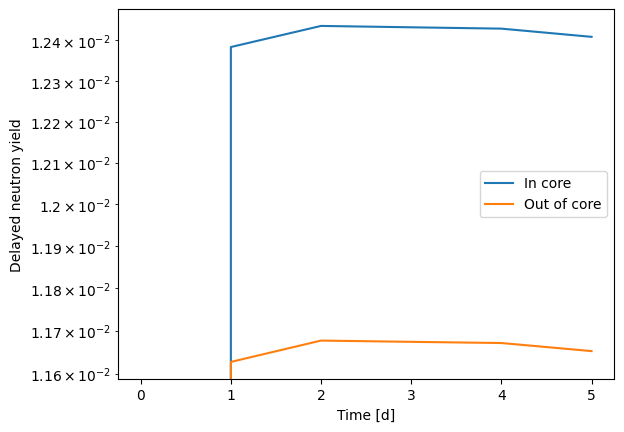

In [441]:
#delayed neutron yield (DN/Fiss)
vd_core = dn_core/fr
vd_ofc = dn_ofc/fr
print(f'Total: {vd_core+vd_ofc}')
fig, ax = plt.subplots()
ax.plot(vd_core, label='In core')
ax.plot(vd_ofc, label='Out of core')
plt.legend()
ax.set_xlabel('Time [d]')
ax.set_ylabel('Delayed neutron yield')
ax.set_yscale('log')
plt.show()